In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

from mtcnn import MTCNN
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

import os
import re

from keras.layers import Embedding
from keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [4]:
df = pd.read_csv('MELD.Raw/dev_sent_emo.csv',encoding='utf-8')
df['Utterance'] = df.Utterance.str.replace('',"'")
# df['gender'] = df.Speaker.apply(lambda x: 'male' if x == 'Ross' or x == 'Joey' or x == 'Chandler' else 'female')
df = df.sample(frac=0.02,ignore_index=True)
df

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,269,It was my,Ross,neutral,neutral,22,10,1,4,"00:18:07,586","00:18:10,379"
1,945,Stop the bus! Wait! Wait! Wait!,Joey,fear,negative,89,2,2,6,"00:12:10,730","00:12:15,525"
2,412,"Oh, hi. It's Mark.",Mark,neutral,neutral,35,0,3,12,"00:04:18,258","00:04:20,384"
3,1136,I guess I set up the video camera to try and e...,Monica,neutral,neutral,109,0,5,9,"00:20:41,823","00:20:46,077"
4,593,But I won't have aged at all.,Joey,neutral,neutral,56,14,3,22,"00:21:06,098","00:21:08,557"
5,659,Are you kidding?!,Rachel,surprise,positive,63,9,8,18,"0:20:07,527","0:20:08,278"
6,186,"Yeah, and y'know what? I don't give a tiny rat...",Phoebe,anger,negative,16,12,7,5,"00:20:30,187","00:20:33,397"
7,601,Hey Mon!,Ross,joy,positive,57,4,3,1,"0:01:38,014","0:01:38,807"
8,883,Y'know?,Joey,neutral,neutral,82,9,6,21,"0:10:11,706","0:10:12,508"
9,894,What is going on with you? Since when are you ...,Monica,surprise,positive,83,1,8,23,"00:10:33,287","00:10:36,582"


In [5]:
face_model = tf.keras.models.Sequential()

face_model.add(tf.keras.layers.Conv2D(50, (3, 3), strides=1, padding="same", activation="relu", 
                input_shape=(224, 224, 3)))


## comment out for embeddings only  ##

# face_model.add(tf.keras.layers.Flatten())
# face_model.add(tf.keras.layers.Dense(256, activation='relu'))
# face_model.add(tf.keras.layers.Dense(len(df.Emotion.unique())))
# face_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])



In [6]:
detector = MTCNN()

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0 
    return img

def extract_face_embeddings(frame):
    global face_embedding
    faces = detector.detect_faces(frame)
    face_embeddings = []
    for face in faces:
        x, y, w, h = face['box']
        x1, y1 = max(x, 0), max(y, 0)
        x2, y2 = min(x + w, frame.shape[1]), min(y + h, frame.shape[0])
        cropped_face = frame[y1:y2, x1:x2]
        
        # Preprocess
        preprocessed_face = preprocess_image(cropped_face)
        preprocessed_face = np.expand_dims(preprocessed_face, axis=0)

        face_embedding = face_model.predict(preprocessed_face)
        face_embeddings.append(np.squeeze(face_embedding))
        
        return face_embeddings

# Read video
folder_path = 'MELD.Raw/dev_splits_complete/'
one_face_videos = {}

for idx, row in df.iterrows():
    file_name = 'dia' + str(row['Dialogue_ID']) + '_utt' + str(row['Utterance_ID']) + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 2:
            ret, frame = video_capture.read()
            if not ret:
                break

            # check for more than 1 face
            if len(detector.detect_faces(frame)) == 1:

                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame

                # bounding boxes
                for face in detector.detect_faces(frame):
                    x, y, w, h = face['box']
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                cv2.imshow('Video', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            one_face_videos[file_name] = np.squeeze(single_video_embeddings)
        else:
            one_face_videos[file_name] = 'too many faces'


1/1 [==============================] - 0s 27ms/step


In [7]:
df['many_faces'] = one_face_videos.values()

df = df[df.many_faces != 'too many faces']

print(len(df))

19


c:\Users\gsevr\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


In [8]:
b = []

for value in one_face_videos.values():
    if value != 'too many faces':
        b.append(value)


visual = np.array(b)

C:\Users\gsevr\AppData\Local\Temp\ipykernel_24332\2504829242.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if value != 'too many faces':


In [11]:
padding_length = 30

from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


def preprocess(text):
    t = text.lower()
    t = re.sub('\d+',r'',t)
    t = re.sub(r'\W+',r' ',t)
    return t

lemmatizer = WordNetLemmatizer()



df['prepro'] = [' '.join([lemmatizer.lemmatize(preprocess(txt))])
                 .strip() for txt in df['Utterance']]


texts = df.prepro.values
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(texts)


C:\Users\gsevr\AppData\Local\Temp\ipykernel_24332\3695085137.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prepro'] = [' '.join([lemmatizer.lemmatize(preprocess(txt))])


In [10]:
from gensim.models import KeyedVectors


glove_path = 'glove.6B.300d.txt'
word_vectors = KeyedVectors.load_word2vec_format(glove_path, binary=False, encoding='utf8',no_header=True)
glove_dims = 300



In [12]:
ohe = OneHotEncoder(categories=[df.Emotion.unique()])
labels = ohe.fit_transform(df.Emotion.to_numpy().reshape(-1,1)).toarray()

sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=padding_length, padding='post')

# X_train, X_test, y_train, y_test = train_test_split(texts, labels,test_size=0.25)

# sequences = tokenizer.texts_to_sequences(X_train)
# padded_sequences = pad_sequences(sequences, maxlen=padding_length, padding='post')

# test = tokenizer.texts_to_sequences(X_test)
# test_sequences = pad_sequences(test, maxlen=padding_length, padding='post')


In [13]:


embedding_dim = glove_dims  
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

embedding_layer = Embedding(
    input_dim=len(tokenizer.word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=padding_length,  #for matmul
    trainable=False
)

In [14]:
# text embeddings model

text_model = tf.keras.Sequential()

text_model.add(embedding_layer)

text_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics='accuracy')

text_embeddings = text_model.predict(padded_sequences)

1/1 [==============================] - 0s 44ms/step


In [15]:

agg_vis = []

for i in visual:
    agg_vis.append(tf.reduce_mean(i, axis=0))

agg_vis = np.array(agg_vis)

In [16]:
con_ten = []

for i in range(len(df)):
    con_ten.append(np.concatenate([text_embeddings.ravel(),agg_vis.ravel()]))

df['concat'] = con_ten

C:\Users\gsevr\AppData\Local\Temp\ipykernel_24332\995383175.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['concat'] = con_ten


In [17]:
model = Sequential()


model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(df.Emotion.unique()), activation='relu'))


model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

In [18]:
history = model.fit(epochs=10,batch_size=32,x=np.stack(con_ten),y=labels)

Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: nan - accuracy: 0.6000
Epoch 2/10
1/1 [==============================] - 5s 5s/step - loss: nan - accuracy: 0.6000
Epoch 3/10
1/1 [==============================] - 5s 5s/step - loss: nan - accuracy: 0.6000
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: nan - accuracy: 0.6000
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: nan - accuracy: 0.6000
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: nan - accuracy: 0.6000
Epoch 7/10
1/1 [==============================] - 4s 4s/step - loss: nan - accuracy: 0.6000
Epoch 8/10
1/1 [==============================] - 4s 4s/step - loss: nan - accuracy: 0.6000
Epoch 9/10
1/1 [==============================] - 4s 4s/step - loss: nan - accuracy: 0.6000
Epoch 10/10
1/1 [==============================] - 4s 4s/step - loss: nan - accuracy: 0.6000


In [ ]:
#model for text 


# model = tf.keras.Sequential()

# model.add(embedding_layer)
# model.add(layers.Dropout(0.4))

# model.add(layers.Reshape((-1,glove_dims)))
# model.add(layers.Bidirectional(layers.GRU(128,activation='tanh')))
# model.add(layers.Dropout(0.4))
# model.add(layers.Dense(len(df.Emotion.unique()), activation='softmax'))

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics='accuracy')
# history = model.fit(padded_sequences, y_train, epochs=20)

' Model for text '

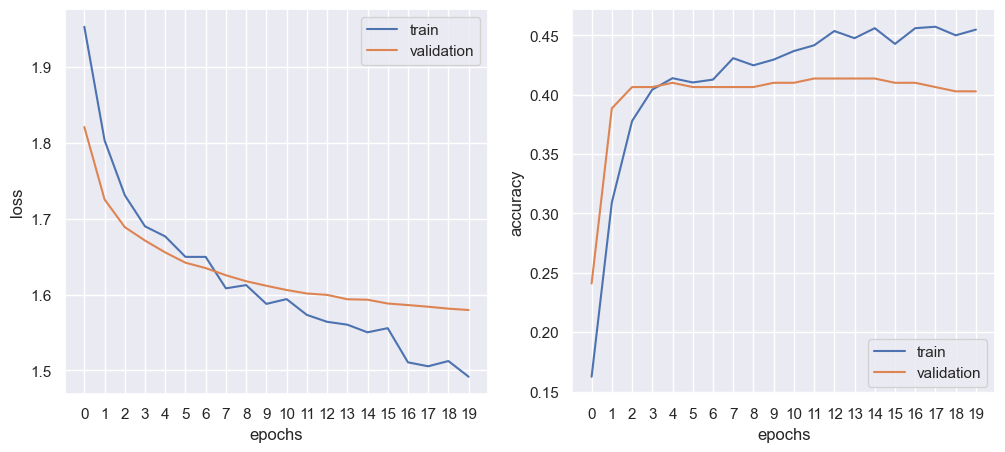

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks([i for i in range(0,20)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper right')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='lower right')
plt.xticks([i for i in range(0,20)])

plt.show()